In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import sys
import copy
import pickle
import numpy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.pyplot import figure, subplots, imshow, xticks, yticks, title
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from statistics import mean
from scipy.stats import entropy
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from statistics import mean
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import time
import copy


In [3]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim**0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

In [4]:
class NetRNN(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.rnnLayer(x, self.h0)
        out = torch.tanh(out)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                out, h0 = self.rnnLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())
            out = torch.tanh(out)
            out = torch.tanh(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)


In [5]:
class NetRNNWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True, nonlinearity='tanh')
        
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)

        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # RNN processing
        h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        rnn_out, _ = self.rnnLayer(expanded_attn_out, h0)
        rnn_out = torch.tanh(rnn_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(rnn_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # RNN processing
                out, h0 = self.rnnLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)


In [6]:
class NetRNNWithAttentionExpFirst(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttentionExpFirst, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # Attention layer applied after expansion
        self.attention = SelfAttention(self.hidden_dim)  # Assuming SelfAttention is defined elsewhere

        # RNN layer
        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True, nonlinearity='tanh')

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        expanded_x = self.expand_layer(x)
        expanded_x = torch.tanh(expanded_x)

        # Apply attention
        attn_out = self.attention(expanded_x)

        # RNN processing
        h0 = torch.zeros(1, attn_out.shape[0], self.hidden_dim)
        rnn_out, _ = self.rnnLayer(attn_out, h0)
        rnn_out = torch.tanh(rnn_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(rnn_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Apply the expansion layer with tanh activation
                expanded_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                expanded_input = torch.tanh(expanded_input)

                # Applying attention to each timestep
                attn_out = self.attention(expanded_input)

                # RNN processing
                out, h0 = self.rnnLayer(attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetRNNWithAttention(hidden_dim=12)


In [7]:
class NetLSTM(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), 1, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim/2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        # Initialize hidden and cell states
        self.h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)),
                   torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))

        # LSTM processing
        out, self.h0 = self.lstmLayer(x, self.h0)
        out = torch.tanh(out)  # Apply tanh to the LSTM output if needed

        # Concatenate hidden and cell states
        hh = numpy.concatenate((self.h0[0].detach().numpy(), self.h0[1].detach().numpy()), 2)
        self.hidden.append(hh)

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                out, h0 = self.lstmLayer(step_input, h0)
                hh = numpy.concatenate((h0[0].detach().numpy().flatten(), h0[1].detach().numpy().flatten()))
                H.append(hh.flatten())

            out = torch.tanh(out)  # Apply tanh to the LSTM output if needed
            out = torch.tanh(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)
    
model = NetLSTM(hidden_dim=12)


In [8]:
class NetLSTMWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTMWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim/2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)

        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # LSTM processing
        h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)),
              torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))
        lstm_out, _ = self.lstmLayer(expanded_attn_out, h0)
        lstm_out = torch.tanh(lstm_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(lstm_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # LSTM processing
                out, h0 = self.lstmLayer(expanded_attn_out, h0)
                H.append(torch.cat((h0[0].detach(), h0[1].detach()), 2).numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)
    
model = NetLSTMWithAttention(hidden_dim=12)


In [9]:

class NetLSTMWithAttentionExpFirst(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTMWithAttentionExpFirst, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer first
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # Attention layer applied after expansion
        self.attention = SelfAttention(self.hidden_dim)  # Assuming SelfAttention is defined elsewhere

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim / 2), batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim / 2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        expanded_x = self.expand_layer(x)
        expanded_x = torch.tanh(expanded_x)

        # Apply attention
        attn_out = self.attention(expanded_x)

        # LSTM processing
        h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim / 2)),
              torch.zeros(1, x.shape[0], int(self.hidden_dim / 2)))
        lstm_out, _ = self.lstmLayer(attn_out, h0)
        lstm_out = torch.tanh(lstm_out)

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(lstm_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim / 2)),
                  torch.zeros(1, 1, int(self.hidden_dim / 2)))
            for i in range(x.shape[1]):
                # Apply the expansion layer with tanh activation
                expanded_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                expanded_input = torch.tanh(expanded_input)

                # Applying attention to each timestep
                attn_out = self.attention(expanded_input)

                # LSTM processing
                out, h0 = self.lstmLayer(attn_out, h0)
                H.append(torch.cat((h0[0].detach(), h0[1].detach()), 2).numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetLSTMWithAttention(hidden_dim=12)


In [10]:
class NetGRU(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(x, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                # GRU processing
                out, h0 = self.gruLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)
    
model = NetGRU(hidden_dim=12)


In [11]:
class NetGRUMWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRUMWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)

        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(expanded_attn_out, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # GRU processing
                out, h0 = self.gruLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetGRUMWithAttention(hidden_dim=12)


In [12]:
class NetGRUMWithAttentionExpFirst(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRUMWithAttentionExpFirst, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer first
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # Attention layer applied after expansion
        self.attention = SelfAttention(self.hidden_dim)  # Assuming SelfAttention is defined elsewhere

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        expanded_x = self.expand_layer(x)
        expanded_x = torch.tanh(expanded_x)

        # Apply attention
        attn_out = self.attention(expanded_x)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(attn_out, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Apply the expansion layer with tanh activation
                expanded_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                expanded_input = torch.tanh(expanded_input)

                # Applying attention to each timestep
                attn_out = self.attention(expanded_input)

                # GRU processing
                out, h0 = self.gruLayer(attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetGRUMWithAttention(hidden_dim=12)


In [13]:
def generateTrainData(num_samples, min_max):
    s = []  # Sequences
    t = []  # Labels
    params = {
    "min_length": min_max[0],
    "max_length": min_max[1],
    "fill": 0,
    "value_1": -1,
    "value_2": 1,
}
    for _ in range(num_samples):
        common_length = np.random.randint(params["min_length"], params["max_length"] + 1)

        array_A = np.full(common_length, params["fill"])
        array_B = np.full(common_length, params["fill"])
        array_C = np.full(common_length, params["fill"])

        # Exclude the last two indices
        possible_indices = np.arange(common_length - 2)

        index_A = np.random.choice(possible_indices)
        value_A = np.random.choice([params["value_1"], params["value_2"]])
        array_A[index_A] = value_A

        # Update possible indices for array B to also exclude index_A
        possible_indices_B = np.delete(possible_indices, np.where(possible_indices == index_A))
        index_B = np.random.choice(possible_indices_B)
        value_B = np.random.choice([params["value_1"], params["value_2"]])
        array_B[index_B] = value_B

        value_C = np.random.choice([params["value_1"], params["value_2"]])
        array_C[-1] = value_C
        array_C[-2] = value_C

        mapped_value_A = 1 if value_A == params["value_2"] else 0
        mapped_value_B = 1 if value_B == params["value_2"] else 0
        #value_1 = -1
        #value_2 = 1
        if value_C == params["value_1"]: # XOR
            result = int(mapped_value_A != mapped_value_B) 
        else : # XNOR
            result =  int(mapped_value_A == mapped_value_B)

        # Mapping back to original value_1 and value_2 for the label
        label_value_A = params["value_2"] if mapped_value_A == 1 else params["value_1"]
        label_value_B = params["value_2"] if mapped_value_B == 1 else params["value_1"]
        results_XORNOR= params["value_2"] if result == 1 else params["value_1"]

        #label_arr = [mapped_value_A, mapped_value_B, result]  # Label array with value_A, value_B, and result
        label_arr = [label_value_A, label_value_B, results_XORNOR]  # Label array with value_A, value_B, and result

        combined_array = np.vstack([array_A, array_B, array_C]).T
        s.append(combined_array)
        t.append(label_arr)

    return s, np.array(t)


In [14]:
num_seq = 1
# Example dictionary with parameters
sequences, labels = generateTrainData(num_seq, [5,5])
print(sequences)
print(labels)

[array([[ 0, -1,  0],
       [ 1,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  1],
       [ 0,  0,  1]])]
[[ 1 -1 -1]]


In [15]:

sequences, labels = generateTrainData(1, [10,10])
model = NetRNN()
output=model(torch.Tensor(sequences))
print(torch.Tensor(sequences))
print(output.shape)
print(model)

tensor([[[ 0.,  0.,  0.],
         [ 0.,  1.,  0.],
         [-1.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0., -1.],
         [ 0.,  0., -1.]]])
torch.Size([1, 3])
NetRNN(
  (expand_layer): Linear(in_features=3, out_features=12, bias=True)
  (rnnLayer): RNN(12, 12, batch_first=True)
  (outputLayer): Linear(in_features=12, out_features=3, bias=True)
)


/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_44271/996492457.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  output=model(torch.Tensor(sequences))


/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_44271/667699806.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


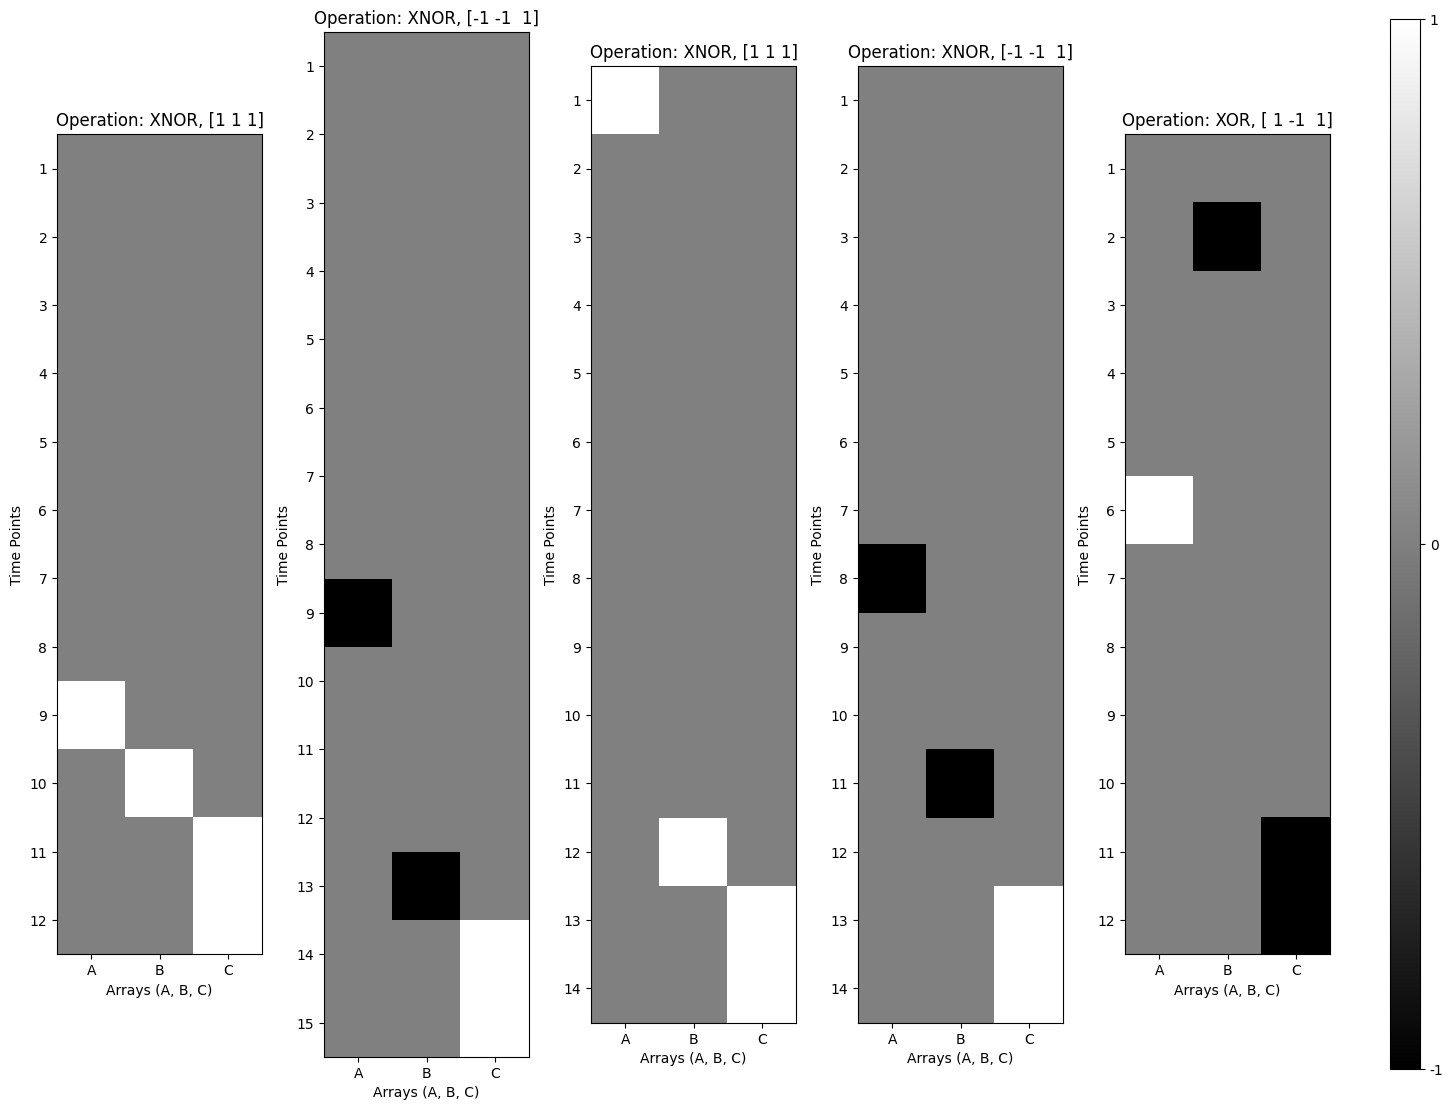

In [16]:

sequences, labels = generateTrainData(5, [10,15])

def plot_sequences(sequences, labels):
    num_samples = len(sequences)  # Number of samples to display

    # Plotting
    plt.figure(figsize=(3 * num_samples, 15))

    for i, (seq, label) in enumerate(zip(sequences, labels)):
        reshaped_sequence = seq  # Use the sequence as it is

        ax = plt.subplot(1, num_samples, i + 1)
        img = ax.imshow(
            reshaped_sequence, cmap="gray", vmin=-1.0, vmax=1.0
        )  # Adjusted vmin and vmax
        operation_title = "XOR" if seq[-1][2] == -1 else "XNOR"
        ax.set_title(f"Operation: {operation_title}, {label}")

        ax.set_xlabel("Arrays (A, B, C)")
        ax.set_ylabel("Time Points")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["A", "B", "C"])
        ax.set_yticks(range(reshaped_sequence.shape[0]))
        ax.set_yticklabels([f"{j+1}" for j in range(reshaped_sequence.shape[0])])

    # Adjusted positioning of colorbar
    cbar_ax = plt.gcf().add_axes([0.93, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(img, cax=cbar_ax)
    cbar.set_ticks([-1, 0, 1])
    cbar.set_ticklabels(["-1", "0", "1"])

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()


# Example usage
# Assuming sequences and labels are already generated using generateTrainData
plot_sequences(sequences, labels)

In [17]:
parameters_list = []

# min_lengths = [5, 10, 10, 20, 20, 40, 40, 70,100]
# max_lengths = [5, 10, 15, 20, 25, 40, 45,75,140]
min_lengths = [5]
max_lengths = [5]


In [18]:
collectorA = dict()
num_samples = 100
for rep in range(1):  # Number of repetitions
    for min_len, max_len in zip(min_lengths, max_lengths):
        # Select the model based on 'kind'
        for kind in ["RNN", "NetRNNWithAttention", "NetRNNWithAttentionExpFirst","LSTM", "NetLSTMWithAttention","NetLSTMWithAttentionExpFirst" "GRU", "NetGRUWithAttention","NetGRUWithAttentionExpFirst"]:
            if kind == "RNN":
                model = NetRNN(hidden_dim=12, inp=3)
            elif kind == "NetRNNWithAttention":
                model = NetRNNWithAttention(hidden_dim=12, inp=3)
            elif kind == "NetRNNWithAttentionExpFirst":
                model = NetRNNWithAttentionExpFirst(hidden_dim=12, inp=3)
            elif kind == "LSTM":
                model = NetLSTM(hidden_dim=12, inp=3)
            elif kind == "NetLSTMWithAttention":
                model = NetLSTMWithAttention(hidden_dim=12, inp=3)
            elif kind == "NetLSTMWithAttentionExpFirst":
                model = NetLSTMWithAttentionExpFirst(hidden_dim=12, inp=3)
            elif kind == "GRU":
                model = NetGRU(hidden_dim=12, inp=3)
            elif kind == "NetGRUWithAttention":
                model = NetGRUMWithAttention(hidden_dim=12, inp=3)
            elif kind == "NetGRUWithAttentionExpFirst":
                model = NetGRUMWithAttentionExpFirst(hidden_dim=12, inp=3)

            optimizer = optim.Adam(model.parameters())
            criterion = nn.MSELoss()
            acc = 0.0
            W = []
            AC = []
            start_time = time.time()  # Start time of the epoch

            while True:
                sequences, targets = generateTrainData(num_samples, [min_len,max_len])
                total_loss = 0
                total_acc = 0
                count = 0

                for seq, target in zip(sequences, targets):
                    optimizer.zero_grad()
                    seq_tensor = torch.Tensor([seq])  # Add an extra dimension for batch
                    target_tensor = torch.Tensor([target])

                    output = model(seq_tensor)
                    loss = criterion(output, target_tensor)
                    total_loss += loss.item()

                    loss.backward()
                    optimizer.step()

                    # Calculate accuracy
                    A = 1.0 * (target_tensor.detach() > 0.0)
                    B = 1.0 * (output.detach() > 0.0)
                    acc = (1.0 * (A.flatten() == B.flatten())).mean()
                    total_acc += acc
                    count += 1

                avg_loss = total_loss / count
                avg_acc = total_acc / count
                W.append(avg_loss)
                AC.append(avg_acc)
                print(f"{kind}, rep: {rep}, epoch: {len(AC)}, acc: {avg_acc}, Loss {avg_loss}")

                # Check for stopping condition
                if avg_acc >= 0.97:
                    break

            end_time = time.time()  # End time of the epoch
            epoch_duration = end_time - start_time  # Calculate duration
            collectorA[f"{kind} {rep}"] = A
            torch.save(model, f'models/model_{kind}_min_{min_len}_max_{max_len}.model')
            print(f"{kind:<20} Rep: {rep:<3} Epoch: {len(A):<5} Acc: {avg_acc:.4f} " f"_min_{min_len}_max_{max_len} Time: {epoch_duration:.2f} sec")

RNN, rep: 0, epoch: 1, acc: 0.4766666293144226, Loss 1.0333330261707305
RNN, rep: 0, epoch: 2, acc: 0.6233333349227905, Loss 0.8987798437476158
RNN, rep: 0, epoch: 3, acc: 0.6766667366027832, Loss 0.7157488378882408
RNN, rep: 0, epoch: 4, acc: 0.7533335089683533, Loss 0.6587239870429039
RNN, rep: 0, epoch: 5, acc: 0.7666666507720947, Loss 0.646464870274067
RNN, rep: 0, epoch: 6, acc: 0.7666667103767395, Loss 0.630634680390358
RNN, rep: 0, epoch: 7, acc: 0.830000102519989, Loss 0.5540106572210789
RNN, rep: 0, epoch: 8, acc: 0.8933331966400146, Loss 0.4862050719559193
RNN, rep: 0, epoch: 9, acc: 0.9033331871032715, Loss 0.5294290915131569
RNN, rep: 0, epoch: 10, acc: 0.9366666674613953, Loss 0.4459863747656345
RNN, rep: 0, epoch: 11, acc: 0.9866666197776794, Loss 0.3323946486413479
RNN                  Rep: 0   Epoch: 1     Acc: 0.9867 _min_5_max_5 Time: 0.92 sec
NetRNNWithAttention, rep: 0, epoch: 1, acc: 0.596666693687439, Loss 0.9665626114606858


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


NetRNNWithAttention, rep: 0, epoch: 2, acc: 0.6200001239776611, Loss 0.92885617852211
NetRNNWithAttention, rep: 0, epoch: 3, acc: 0.7133334875106812, Loss 0.7693475764989853
NetRNNWithAttention, rep: 0, epoch: 4, acc: 0.6766667366027832, Loss 0.6931993746757508
NetRNNWithAttention, rep: 0, epoch: 5, acc: 0.6800000667572021, Loss 0.6768368011713028
NetRNNWithAttention, rep: 0, epoch: 6, acc: 0.7600000500679016, Loss 0.6010318824648857
NetRNNWithAttention, rep: 0, epoch: 7, acc: 0.8199998736381531, Loss 0.5211881899833679
NetRNNWithAttention, rep: 0, epoch: 8, acc: 0.9033333659172058, Loss 0.4460917341709137
NetRNNWithAttention, rep: 0, epoch: 9, acc: 0.9599999189376831, Loss 0.3108935564756393
NetRNNWithAttention, rep: 0, epoch: 10, acc: 0.996666669845581, Loss 0.22502273097634315
NetRNNWithAttention  Rep: 0   Epoch: 1     Acc: 0.9967 _min_5_max_5 Time: 1.19 sec
NetRNNWithAttentionExpFirst, rep: 0, epoch: 1, acc: 0.6199999451637268, Loss 0.9683741354942321
NetRNNWithAttentionExpFirst, r

In [19]:
# Load the model
model = torch.load("./models/model_RNN_min_10_max_10.model")
model.eval()  # Set the model to evaluation mode


# Assuming generateTrainData is defined and returns sequences and targets
sequences, targets = generateTrainData(1000, [10,10])

# Convert sequences and targets to tensors and pad sequences
seq_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
padded_seq_tensors = pad_sequence(seq_tensors, batch_first=True)
target_tensors = torch.tensor(targets, dtype=torch.float32)

# Define the loss function
criterion = nn.MSELoss()

# Evaluate the model on test data
with torch.no_grad():
    total_acc = 0.0
    total_loss = 0.0

    for seq_tensor, target_tensor in zip(padded_seq_tensors, target_tensors):
        # Add batch dimension
        seq_tensor = seq_tensor.unsqueeze(0)
        target_tensor = target_tensor.unsqueeze(0)

        output = model(seq_tensor)

        # Calculate the loss
        loss = criterion(output, target_tensor)
        total_loss += loss.item()

        # Calculate accuracy
        A = 1.0 * (target_tensor.detach() > 0.0)
        B = 1.0 * (output.detach() > 0.0)
        acc = (1.0 * (A.flatten() == B.flatten())).mean()
        total_acc += acc.item()
    # Calculate average accuracy and loss
    avg_acc = total_acc / len(padded_seq_tensors)
    avg_loss = total_loss / len(padded_seq_tensors)
    print(f"Average Test Accuracy: {avg_acc * 100:.2f}%")
    print(f"Average Test Loss: {avg_loss:.4f}")


Average Test Accuracy: 100.00%
Average Test Loss: 0.2368


In [20]:
# Load the model
model = torch.load("./models/model_NetRNNWithAttention_min_10_max_10.model")
model.eval()  # Set the model to evaluation mode

# Assuming generateTrainData is defined and returns sequences and targets
sequences, targets = generateTrainData(1000, [10,10])

# Convert sequences and targets to tensors and pad sequences
seq_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
padded_seq_tensors = pad_sequence(seq_tensors, batch_first=True)
target_tensors = torch.tensor(targets, dtype=torch.float32)

# Define the loss function
criterion = nn.MSELoss()

# Evaluate the model on test data
with torch.no_grad():
    total_acc = 0.0
    total_loss = 0.0

    for seq_tensor, target_tensor in zip(padded_seq_tensors, target_tensors):
        # Add batch dimension
        seq_tensor = seq_tensor.unsqueeze(0)
        target_tensor = target_tensor.unsqueeze(0)

        output = model(seq_tensor)

        # Calculate the loss
        loss = criterion(output, target_tensor)
        total_loss += loss.item()

        # Calculate accuracy
        A = (target_tensor > 0.0).float()
        B = (output > 0.0).float()
        acc = (A.flatten() == B.flatten()).float().mean()
        total_acc += acc.item()
    # Calculate average accuracy and loss
    avg_acc = total_acc / len(padded_seq_tensors)
    avg_loss = total_loss / len(padded_seq_tensors)
    print(f"Average Test Accuracy: {avg_acc * 100:.2f}%")
    print(f"Average Test Loss: {avg_loss:.4f}")


Average Test Accuracy: 87.27%
Average Test Loss: 0.4810


In [21]:
# This function calculates the entropy of a dataset D using the Shannon entropy formula. Entropy is a measure of the unpredictability or randomness of the data.
def symbolEntropy(D, base=2):
    value, counts = numpy.unique(D, return_counts=True)  # Find unique values and their frequency in D
    return entropy(counts, base=base)  # Calculate and return the Shannon entropy

# This function seems to compute a complex metric, possibly related to information theory, involving inputs I, hidden states H, and outputs O.
def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    # Create various combinations of Inputs (I), Hidden states (H), and Outputs (O) for analysis
    # B, IB, AB, BO, IAB, IBO, ABO, IABO are different combinations of I, H, and O
    # Calculate entropy for each combination using symbolEntropy
    # Return a specific information metric combining these entropies


    #print("I H O",I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

# This function seems to analyze how information is processed or transmitted through a network, focusing on individual components (nodes) of the hidden states H.
def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes = list(range(width))  # Initialize a list of node indices
    cols = []  # To store subsets of nodes
    colh = []  # To store corresponding information values
    # Iteratively remove a node, compute information value, and record subsets and values
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh


# This function processes the output of a model given a dataset. It appears to involve some form of clustering (using KMeans) and then re-encoding the hidden states H.
def getOutTaH(model,dataSet):
    O, H = model.step(torch.Tensor(dataSet))  # Get output and hidden states from the model
    # Transform H using clustering and re-encoding

    #print(H.shape,H.min(),H.max())
    #figure()
    #hist(H.flatten())

    H = H.transpose()  # Transpose H for processing
    O = O.transpose()  # Transpose O for processing
    B = numpy.zeros(H.shape)  # Initialize a matrix to store cluster labels for each hidden state
    # Apply KMeans clustering to each hidden state
    # Recompute H as a combination of cluster labels (B)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        x =len(numpy.unique(a))
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr,n_init=10).fit(a)
        B[i]=kmeans.labels_
        #B[i]=1.0*(H[i]>numpy.median(H[i]))


    H=numpy.zeros((H.shape))
    for i in range(12):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return O,H

# This function seems to integrate the previous functions to analyze how information flows through the network for different input-output pairs in a dataset.
def shrinkingDecompositionInformation(model,width,dataSet,target,numbers=[0,1,2],whichTS=5,dsLength=8):
    output, H = getOutTaH(model, dataSet)  # Get transformed outputs and hidden states from the model
    # Slice output and H to process only specific timesteps

    #print("target.shape",target.shape,"output.shape",output.shape,"H.shape",H.shape,"dataset.shape",dataSet.shape)
    H=H.transpose()[whichTS::dsLength].transpose()
    #target=target.transpose()[whichTS::dsLength].transpose()
    #print(H.shape,target.shape,numpy.array(range(512))[whichTS::dsLength])

    collectorSet = dict()  # To store information about subsets of nodes (S)
    collectorH = dict()    # To store information values (H)
    # Compute shrinking decomposition information for selected inputs/outputs
    for number in numbers:
        I=target[number].astype(int)
        O=(1.0*(output[number]>0.5)).astype(int)
        #print("O",O,"T",target[number])
        #print(number,"I.shape",I.shape,"O.shape",O.shape,"H.shape",H.shape)
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH


# These functions convert the results of the shrinking decomposition into vector and matrix forms, which are likely used for further analysis or visualization.
def removalIntoVec(res,width,H):
    # Convert the shrinking decomposition results into a vector form

    V = numpy.zeros(width)  # Initialize a vector
    # Calculate values for V based on the difference in information values (H) as nodes are removed
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    nRes=copy.deepcopy(res)
    nRes.insert(0,fullSet)
    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    for i,node in enumerate(nodeList):
        V[node]=H[0]-H[i]
    #V=sqrt(V)
    if V.sum()==0:
        return V
    return V#/V.max()

def removalIntoMatrix(res,width,H):
    # Convert the shrinking decomposition results into a matrix form

    M=[]
    # Convert the shrinking decomposition results (S and H) into a matrix form
    # This matrix can be used for visualization or further analysis
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)

Plot 0 - Min: 0.0, Max: 0.17095059445466831
S - 0 {0: [[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11], [0, 1, 2, 3, 5, 7, 8, 9, 10, 11], [0, 1, 2, 3, 5, 8, 9, 10, 11], [0, 1, 2, 3, 5, 9, 10, 11], [0, 1, 2, 3, 5, 10, 11], [1, 2, 3, 5, 10, 11], [1, 3, 5, 10, 11], [3, 5, 10, 11], [5, 10, 11], [10, 11], [11], []], 1: [[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11], [0, 1, 2, 3, 5, 7, 8, 9, 10, 11], [0, 1, 2, 3, 5, 8, 9, 10, 11], [0, 1, 2, 3, 5, 9, 10, 11], [0, 1, 2, 3, 5, 10, 11], [0, 2, 3, 5, 10, 11], [2, 3, 5, 10, 11], [3, 5, 10, 11], [5, 10, 11], [10, 11], [11], []], 2: [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [3, 4, 5, 6, 7, 8, 9, 10, 11], [4, 5, 6, 7, 8, 9, 10, 11], [5, 6, 7, 8, 9, 10, 11], [6, 7, 8, 9, 10, 11], [7, 8, 9, 10, 11], [8, 9, 10, 11], [9, 10, 11], [10, 11], [11], []]}
H - 0 {0: [0.17095059445466831, 0.17095059445466831, 0.17095059445466831, 0.17095059445466831, 0.17095059445466831, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1: [0.07290559532005592, 0.07290559532005592, 0

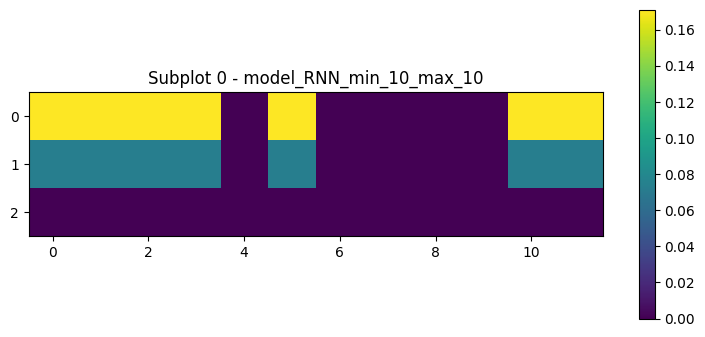

In [31]:
# Load the model
model = torch.load("./Models/model_RNN_min_5_max_5.model")
model.eval()  # Set the model to evaluation mode


plt.figure(figsize=(15, 20))  # Adjust the size as needed

# Run the analysis
for i in range(1):
    s, t = generateTrainData(5, [5,5])  # Use your generateTrainData function
    # Visualize the results
    S,H=shrinkingDecompositionInformation(model,12,s,t.transpose(),numbers=[0,1,2],whichTS=i,dsLength=5)
    subplot(6,2,i+1)
    M=removalIntoMatrix(S,12,H)
    ax = plt.subplot(6, 2, i+1)  # Arrange in 5 rows and 2 columns
    im = ax.imshow(M)
    ax.set_title(f'Subplot {i} - model_RNN_min_10_max_10')
    plt.colorbar(im, ax=ax)  # Add a colorbar to each subplot
    print(f'Plot {i} - Min: {M.min()}, Max: {M.max()}')
    print(f'S - {i} {S}')
    print(f'H - {i} {H}') 
    print(f'M - {i} {M}')
plt.tight_layout()  # Adjust the spacing between plots
plt.show() 

In [40]:
print(len(S))
print(len(S[0]))
print(H[0])
print(len(H[0]))

3
12
[0.17095059445466831, 0.17095059445466831, 0.17095059445466831, 0.17095059445466831, 0.17095059445466831, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
12


Plot 0 - Min: -0.009495223871275549, Max: 0.08959925054777962
s - 0 {0: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 7, 8, 9], [2, 3, 4, 5, 7, 8, 9], [3, 4, 5, 7, 8, 9], [4, 5, 7, 8, 9], [5, 7, 8, 9], [7, 8, 9], [8, 9], [9], []], 1: [[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11], [0, 1, 2, 3, 5, 6, 7, 8, 9, 10], [1, 2, 3, 5, 6, 7, 8, 9, 10], [1, 2, 3, 5, 6, 7, 9, 10], [1, 2, 3, 5, 6, 7, 9], [2, 3, 5, 6, 7, 9], [3, 5, 6, 7, 9], [5, 6, 7, 9], [6, 7, 9], [7, 9], [9], []], 2: [[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [3, 4, 5, 6, 7, 8, 9, 10, 11], [3, 5, 6, 7, 8, 9, 10, 11], [5, 6, 7, 8, 9, 10, 11], [5, 7, 8, 9, 10, 11], [7, 8, 9, 10, 11], [7, 9, 10, 11], [7, 9, 11], [9, 11], [11], []]}
H - 0 {0: [0.08959925054778006, 0.08608577337506995, 0.08608577337506995, 0.08608577337506995, 4.440892098500626e-16, 4.440892098500626e-16, 4.440892098500626e-16, 4.440892098500626e-16, 4.440892098500626e-16, 4.4408920

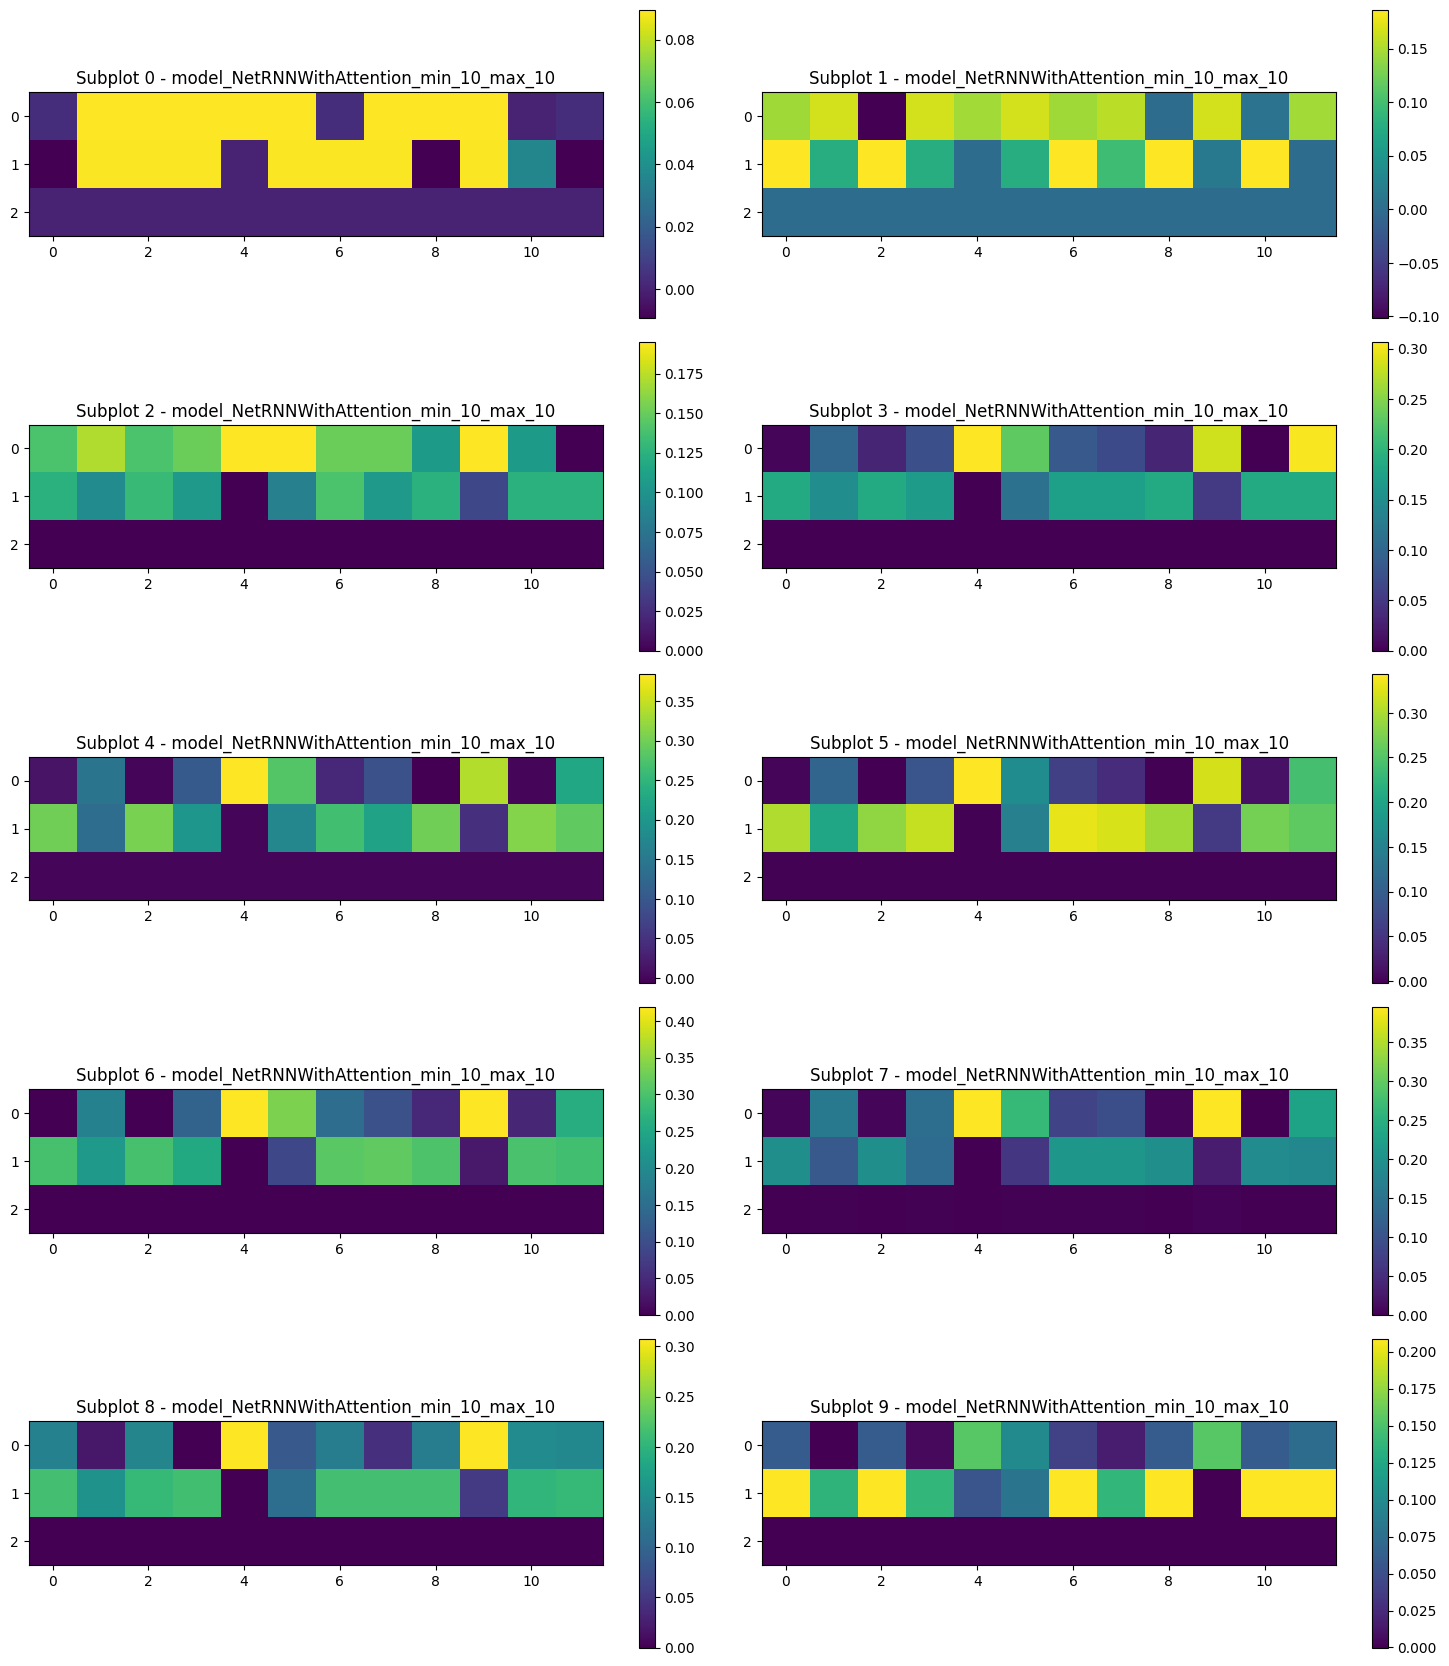

In [24]:
# Load the model
model = torch.load("./Models/model_NetRNNWithAttention_min_10_max_10.model")
model.eval()  # Set the model to evaluation mode


plt.figure(figsize=(15, 20))  # Adjust the size as needed

# Run the analysis
for i in range(10):
    s, t = generateTrainData(100, [10,10])  # Use your generateTrainData function
    # Visualize the results
    S,H=shrinkingDecompositionInformation(model,12,s,t.transpose(),whichTS=i,dsLength=10)
    subplot(6,2,i+1)
    M=removalIntoMatrix(S,12,H)
    ax = plt.subplot(6, 2, i+1)  # Arrange in 5 rows and 2 columns
    im = ax.imshow(M)
    ax.set_title(f'Subplot {i} - model_NetRNNWithAttention_min_10_max_10')
    plt.colorbar(im, ax=ax)  # Add a colorbar to each subplot
    print(f'Plot {i} - Min: {M.min()}, Max: {M.max()}')
    print(f's - {i} {S}')
    print(f'H - {i} {H}') 
    print(f'M - {i} {M}')
plt.tight_layout()  # Adjust the spacing between plots
plt.show()    

Plot 0 - Min: 0.0, Max: 0.10436369628526965
s - 0 {0: [[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11], [0, 1, 2, 3, 4, 5, 6, 8, 10, 11], [0, 2, 3, 4, 5, 6, 8, 10, 11], [0, 3, 4, 5, 6, 8, 10, 11], [3, 4, 5, 6, 8, 10, 11], [4, 5, 6, 8, 10, 11], [4, 5, 8, 10, 11], [4, 5, 10, 11], [4, 5, 10], [5, 10], [10], []], 1: [[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11], [0, 1, 2, 3, 4, 5, 6, 8, 10, 11], [0, 2, 3, 4, 5, 6, 8, 10, 11], [0, 3, 4, 5, 6, 8, 10, 11], [3, 4, 5, 6, 8, 10, 11], [4, 5, 6, 8, 10, 11], [5, 6, 8, 10, 11], [6, 8, 10, 11], [8, 10, 11], [10, 11], [11], []], 2: [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [3, 4, 5, 6, 7, 8, 9, 10, 11], [4, 5, 6, 7, 8, 9, 10, 11], [5, 6, 7, 8, 9, 10, 11], [6, 7, 8, 9, 10, 11], [7, 8, 9, 10, 11], [8, 9, 10, 11], [9, 10, 11], [10, 11], [11], []]}
H - 0 {0: [0.028887387971527012, 0.028887387971527012, 0.028779024521576435, 6.189358008334978e-07, 6.189358008334978e-07, 6.189358008334978e-07, 6.189358008334978e-07, 6.189358008334978e-07, 6.1893580

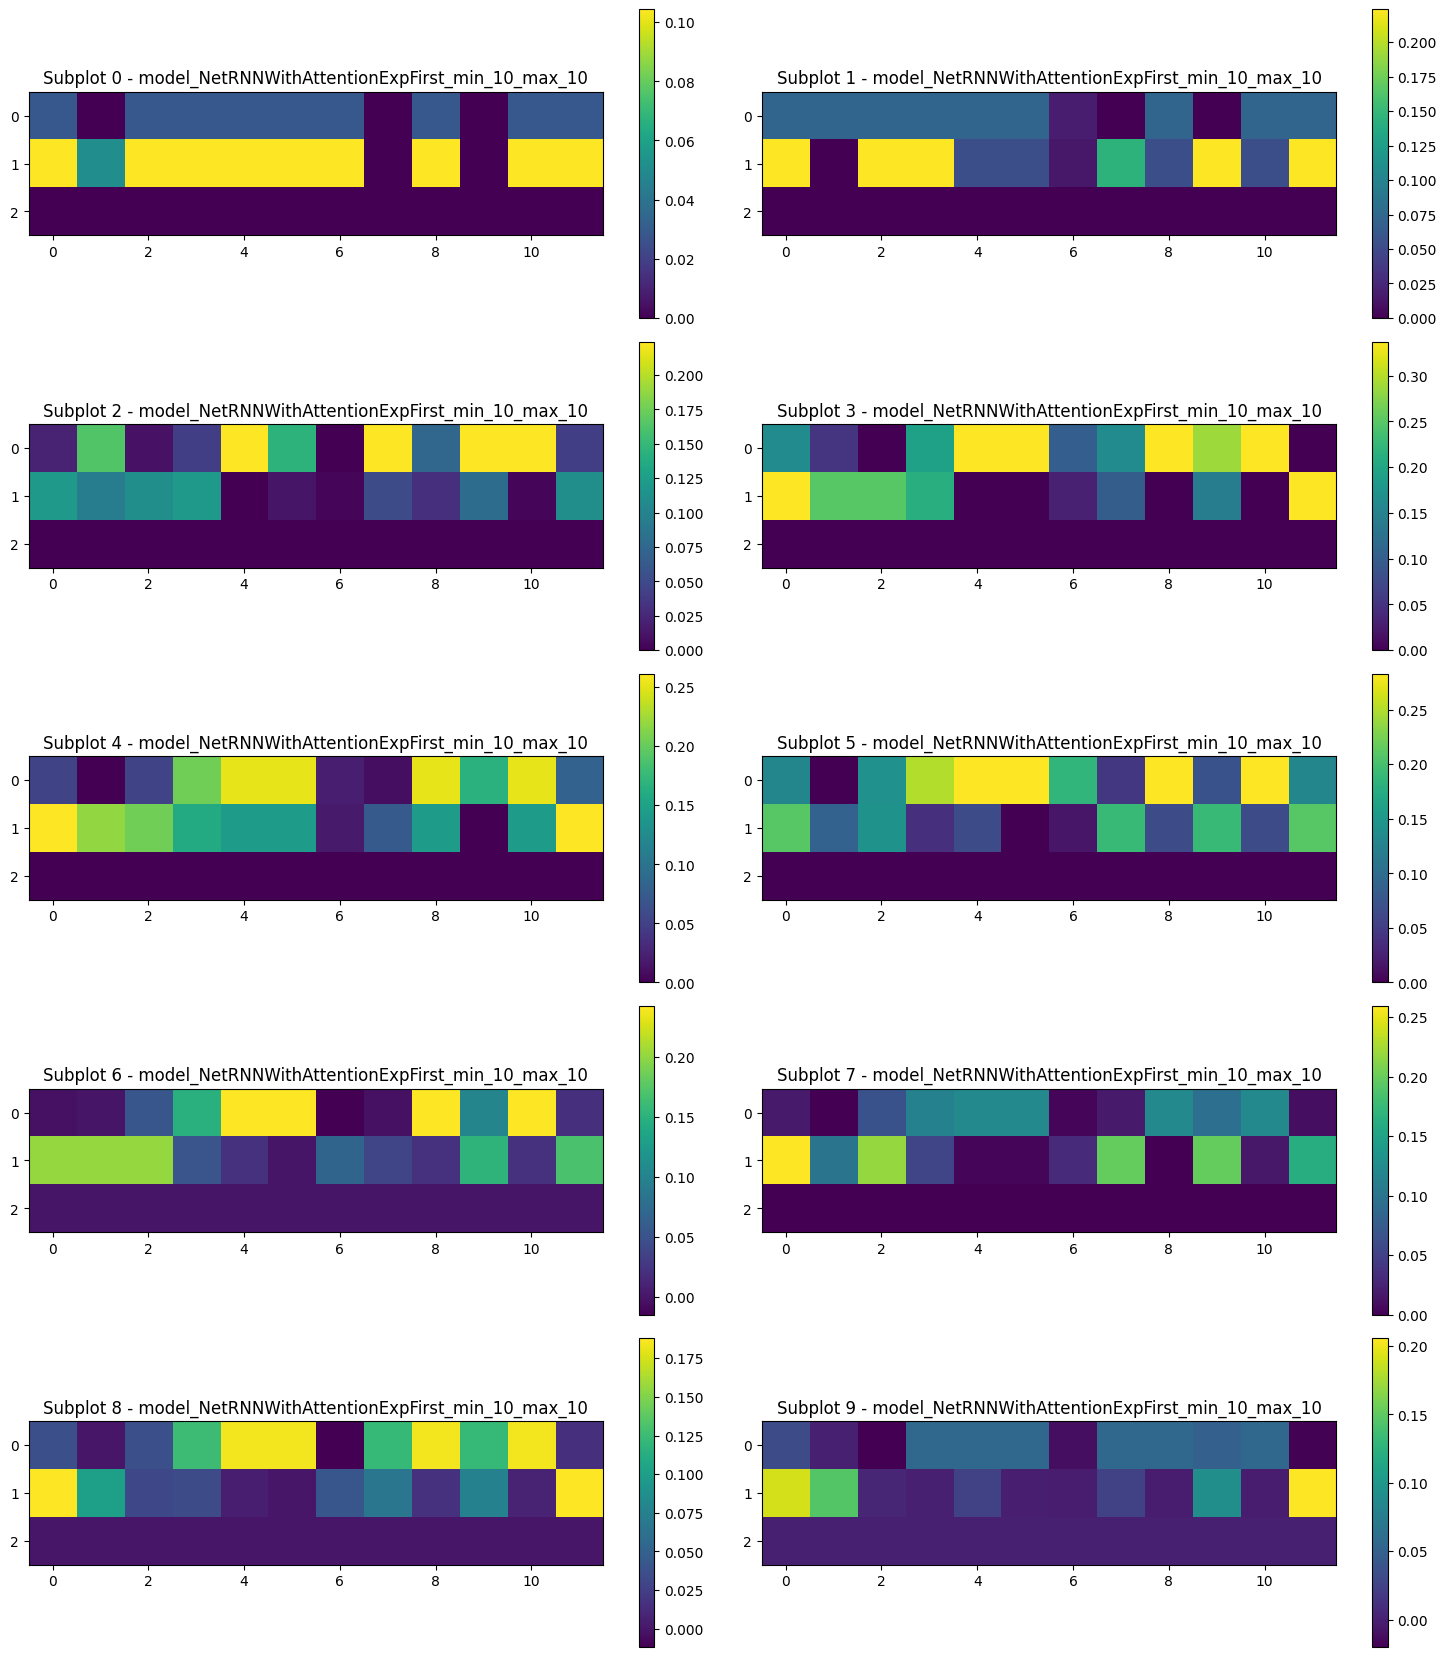

In [25]:
# Load the model
model = torch.load("./Models/model_NetRNNWithAttentionExpFirst_min_10_max_10.model")
model.eval()  # Set the model to evaluation mode


plt.figure(figsize=(15, 20))  # Adjust the size as needed

# Run the analysis
for i in range(10):
    s, t = generateTrainData(100, [10,10])  # Use your generateTrainData function
    # Visualize the results
    S,H=shrinkingDecompositionInformation(model,12,s,t.transpose(),whichTS=i,dsLength=10)
    subplot(6,2,i+1)
    M=removalIntoMatrix(S,12,H)
    ax = plt.subplot(6, 2, i+1)  # Arrange in 5 rows and 2 columns
    im = ax.imshow(M)
    ax.set_title(f'Subplot {i} - model_NetRNNWithAttentionExpFirst_min_10_max_10')
    plt.colorbar(im, ax=ax)  # Add a colorbar to each subplot
    print(f'Plot {i} - Min: {M.min()}, Max: {M.max()}')
    print(f's - {i} {S}')
    print(f'H - {i} {H}') 
    print(f'M - {i} {M}')
plt.tight_layout()  # Adjust the spacing between plots
plt.show()    


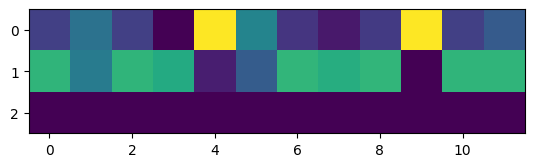

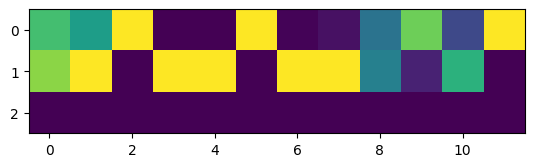

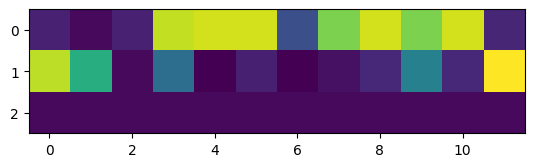

In [26]:

modelRNNWithAttention=torch.load("models/model_RNN_min_10_max_10.model")
modelRNN=torch.load("models/model_NetRNNWithAttention_min_10_max_10.model")
modelRNNWithAttentionExp =torch.load("models/model_NetRNNWithAttentionExpFirst_min_10_max_10.model")
s,t = generateTrainData(100, [10,10])  
S,H=shrinkingDecompositionInformation(modelRNN,12,s,t.transpose(),whichTS=8,dsLength=10)
figure()
imshow(removalIntoMatrix(S,12,H))
S,H=shrinkingDecompositionInformation(modelRNNWithAttention,12,s,t.transpose(),whichTS=8,dsLength=10)
figure()
imshow(removalIntoMatrix(S,12,H))
S,H=shrinkingDecompositionInformation(modelRNNWithAttentionExp,12,s,t.transpose(),whichTS=8,dsLength=10)
figure()
imshow(removalIntoMatrix(S,12,H))